In [52]:
import os
import random
import json
from glob import glob

def prepare_dataset_paths(train_dir, val_dir, split_ratio=0.66, output_json='dataset_paths.json'):
    all_train_classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
    random.shuffle(all_train_classes)

    num_known = int(len(all_train_classes) * split_ratio)
    known_classes = all_train_classes[:num_known]
    unknown_classes = all_train_classes[num_known:]

    dataset_paths = {
        'known_train': [],
        'known_val': [],
        'unknown_val': [],
        'known_classes': known_classes,
        'unknown_classes': unknown_classes,
        'detected_val_classes': []
    }

    for cls in known_classes:
        cls_path = os.path.join(train_dir, cls)
        images = glob(os.path.join(cls_path, '*'))
        dataset_paths['known_train'].extend(images)

    val_classes = sorted([d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, d))])
    dataset_paths['detected_val_classes'] = val_classes

    for cls in val_classes:
        cls_path = os.path.join(val_dir, cls)
        images = glob(os.path.join(cls_path, '*'))
        if cls in known_classes:
            dataset_paths['known_val'].extend(images)
        elif cls in unknown_classes:
            dataset_paths['unknown_val'].extend(images)
        else:
            print(f"⚠️ کلاس '{cls}' در val وجود دارد ولی نه در known و نه در unknown.")

    overlap = set(known_classes).intersection(set(unknown_classes))
    if overlap:
        print("❌ کلاس‌های مشترک بین known و unknown:", overlap)
    else:
        print("✅ هیچ اشتراکی بین known و unknown وجود ندارد.")

    with open(output_json, 'w') as f:
        json.dump(dataset_paths, f, indent=2)

    print(f"✅ مسیر تصاویر آماده شد و در '{output_json}' ذخیره شد.")

prepare_dataset_paths(
    train_dir="/content/drive/MyDrive/train",
    val_dir="/content/drive/MyDrive/val",
    output_json="dataset_paths.json"
)


✅ هیچ اشتراکی بین known و unknown وجود ندارد.
✅ مسیر تصاویر آماده شد و در 'dataset_paths.json' ذخیره شد.


In [53]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, embedding_dim)
        )

    def forward(self, x):
        return self.model(x)


In [54]:
import cv2
import numpy as np
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json
import os

IMG_SIZE = 128

transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
    ToTensorV2()
])

with open('dataset_paths.json', 'r') as f:
    paths = json.load(f)

known_train_paths = paths['known_train']

class FeatureDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"تصویر پیدا نشد: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image

train_dataset = FeatureDataset(known_train_paths, transform=transform)


In [55]:
from collections import defaultdict

def group_images_by_class(image_paths):
    class_to_images = defaultdict(list)
    for path in image_paths:
        cls = os.path.basename(os.path.dirname(path))
        class_to_images[cls].append(path)
    return class_to_images

class_to_images = group_images_by_class(known_train_paths)


In [56]:
import random
import torch
from tqdm import tqdm

class ContrastiveDataset(Dataset):
    def __init__(self, class_to_images, transform=None, num_pairs_per_class=10):
        self.pairs = []
        self.labels = []
        self.transform = transform
        self.class_to_images = class_to_images
        classes = list(class_to_images.keys())

        print("✅ در حال ساخت جفت‌های داده...")
        for cls in tqdm(classes, desc="جفت‌های مثبت"):
            imgs = self.class_to_images[cls]
            if len(imgs) < 2:
                continue
            for _ in range(num_pairs_per_class):
                img1_path, img2_path = random.sample(imgs, 2)
                self.pairs.append((img1_path, img2_path))
                self.labels.append(1)

        num_negative_pairs = len(self.pairs)
        for _ in tqdm(range(num_negative_pairs), desc="جفت‌های منفی"):
            cls1, cls2 = random.sample(classes, 2)
            img1_path = random.choice(self.class_to_images[cls1])
            img2_path = random.choice(self.class_to_images[cls2])
            self.pairs.append((img1_path, img2_path))
            self.labels.append(0)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        path1, path2 = self.pairs[idx]
        label = self.labels[idx]

        img1 = cv2.imread(path1)
        img2 = cv2.imread(path2)
        if img1 is None or img2 is None:
            raise ValueError(f"تصویر خراب: {path1} یا {path2}")

        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

        if self.transform:
            img1 = self.transform(image=img1)['image']
            img2 = self.transform(image=img2)['image']

        return img1, img2, torch.tensor(label, dtype=torch.float32)

contrastive_dataset = ContrastiveDataset(class_to_images, transform=transform)


✅ در حال ساخت جفت‌های داده...


جفت‌های منفی: 100%|██████████| 1760/1760 [00:00<00:00, 310388.72it/s]


In [57]:
from torch.utils.data import DataLoader

contrastive_loader = DataLoader(
    contrastive_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

In [58]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ DEVICE = {DEVICE}")

encoder = Encoder(embedding_dim=128).to(DEVICE)
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)

✅ DEVICE = cuda


In [59]:
import torch.nn.functional as F

def contrastive_loss(embedding1, embedding2, label, margin=1.0):
    distance = F.pairwise_distance(embedding1, embedding2)
    loss = label * torch.pow(distance, 2) + \
           (1 - label) * torch.pow(torch.clamp(margin - distance, min=0.0), 2)
    return loss.mean()

In [72]:
import os
from tqdm import tqdm

def train_encoder_contrastive_with_checkpoint(model, dataloader, optimizer,
                                              epochs=1,
                                              checkpoint_path="/content/drive/MyDrive/checkpoints/encoder_checkpoint.pth"):
    # اگر فولدر وجود نداره بسازش
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

    start_epoch = 0
    if os.path.exists(checkpoint_path):
        print("🟡 Checkpoint موجود است، در حال بارگذاری...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"✅ ادامه آموزش از epoch {start_epoch}")

    model.train()
    for epoch in range(start_epoch, epochs):
        total_loss = 0.0
        for img1, img2, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            img1, img2, labels = img1.to(DEVICE), img2.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            emb1 = model(img1)
            emb2 = model(img2)
            loss = contrastive_loss(emb1, emb2, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, checkpoint_path)
        print(f"💾 Checkpoint ذخیره شد: {checkpoint_path}")

    print("🎉 آموزش کامل شد.")


In [77]:
train_encoder_contrastive_with_checkpoint(
    encoder,
    contrastive_loader,
    optimizer,
    epochs=20,  # اول یک اپوک برای تست
    checkpoint_path="/content/drive/MyDrive/checkpoints/encoder_checkpoint.pth"
)

🟡 Checkpoint موجود است، در حال بارگذاری...
✅ ادامه آموزش از epoch 15


Epoch 16/20: 100%|██████████| 110/110 [01:03<00:00,  1.74it/s]


Epoch 16 - Loss: 0.0676
💾 Checkpoint ذخیره شد: /content/drive/MyDrive/checkpoints/encoder_checkpoint.pth


Epoch 17/20: 100%|██████████| 110/110 [01:01<00:00,  1.79it/s]


Epoch 17 - Loss: 0.0677
💾 Checkpoint ذخیره شد: /content/drive/MyDrive/checkpoints/encoder_checkpoint.pth


Epoch 18/20: 100%|██████████| 110/110 [01:01<00:00,  1.78it/s]


Epoch 18 - Loss: 0.0664
💾 Checkpoint ذخیره شد: /content/drive/MyDrive/checkpoints/encoder_checkpoint.pth


Epoch 19/20: 100%|██████████| 110/110 [01:00<00:00,  1.82it/s]


Epoch 19 - Loss: 0.0682
💾 Checkpoint ذخیره شد: /content/drive/MyDrive/checkpoints/encoder_checkpoint.pth


Epoch 20/20: 100%|██████████| 110/110 [01:01<00:00,  1.79it/s]

Epoch 20 - Loss: 0.0674
💾 Checkpoint ذخیره شد: /content/drive/MyDrive/checkpoints/encoder_checkpoint.pth
🎉 آموزش کامل شد.



🚀 در حال استخراج Embeddingها...


Extracting Embeddings: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]



✅ در حال آموزش NearestNeighbors روی مجموعه آموزشی...


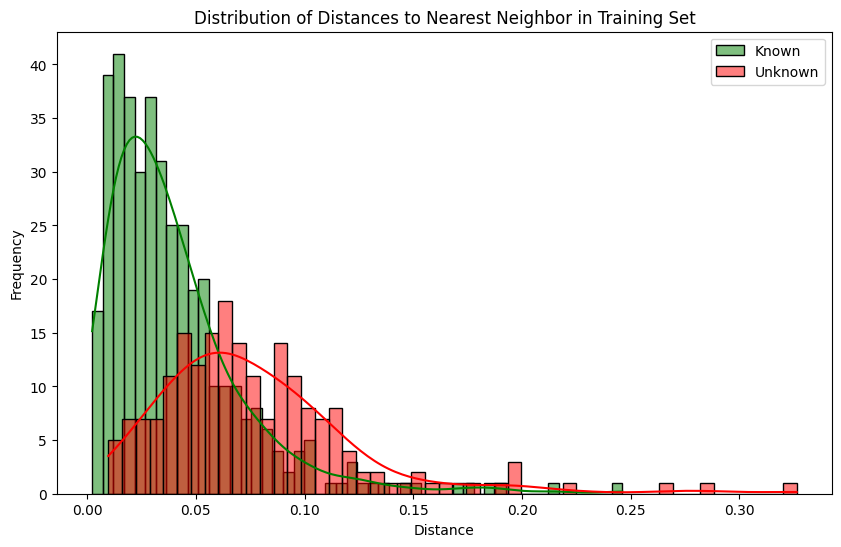


ROC AUC: 0.7913
بهترین threshold بر اساس F1 score: 0.0436
              precision    recall  f1-score   support

       Known       0.87      0.67      0.76       403
     Unknown       0.55      0.80      0.65       200

    accuracy                           0.71       603
   macro avg       0.71      0.73      0.70       603
weighted avg       0.76      0.71      0.72       603


📊 Confusion Matrix:


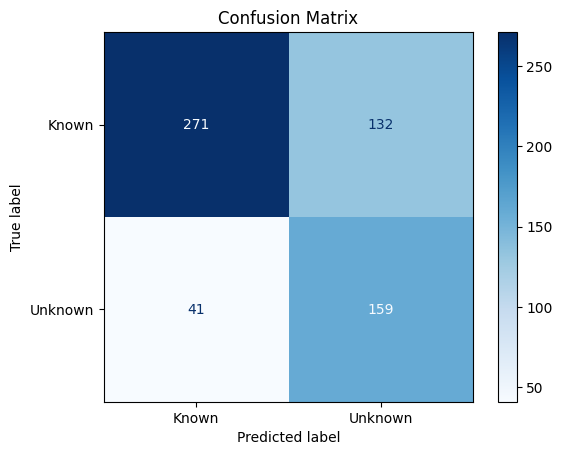

In [78]:
# ---------------------- سلول جدید: کدهای ارزیابی با Confusion Matrix ----------------------
import os
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import json

# 1. آماده‌سازی دیتاست‌ها (فرض می‌کنیم این بخش قبلا تعریف شده)
with open('dataset_paths.json', 'r') as f:
    paths = json.load(f)
known_train_paths = paths['known_train']
known_val_paths = paths['known_val']
unknown_val_paths = paths['unknown_val']

known_train_dataset = FeatureDataset(known_train_paths, transform=transform)
known_val_dataset = FeatureDataset(known_val_paths, transform=transform)
unknown_val_dataset = FeatureDataset(unknown_val_paths, transform=transform)

# 2. استخراج Embedding ها (فرض می‌کنیم تابع extract_embeddings قبلا تعریف شده)
def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for images in tqdm(dataloader, desc="Extracting Embeddings"):
            images = images.to(device)
            emb = model(images)
            embeddings.append(emb.cpu())
    embeddings = torch.cat(embeddings).numpy()
    return embeddings

# بارگذاری مدل آموزش دیده
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(embedding_dim=128).to(DEVICE)
encoder.load_state_dict(torch.load("/content/drive/MyDrive/checkpoints/encoder_checkpoint.pth")['model_state_dict'])

known_train_loader = DataLoader(known_train_dataset, batch_size=32, shuffle=False)
known_val_loader = DataLoader(known_val_dataset, batch_size=32, shuffle=False)
unknown_val_loader = DataLoader(unknown_val_dataset, batch_size=32, shuffle=False)

print("\n🚀 در حال استخراج Embeddingها...")
known_train_emb = extract_embeddings(encoder, known_train_loader, DEVICE)
known_val_emb = extract_embeddings(encoder, known_val_loader, DEVICE)
unknown_val_emb = extract_embeddings(encoder, unknown_val_loader, DEVICE)

# 3. محاسبه فاصله‌ها از نزدیک‌ترین همسایه در مجموعه آموزشی
print("\n✅ در حال آموزش NearestNeighbors روی مجموعه آموزشی...")
nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(known_train_emb)
dist_known_val, _ = nbrs.kneighbors(known_val_emb)
dist_known_val = dist_known_val.flatten()
dist_unknown_val, _ = nbrs.kneighbors(unknown_val_emb)
dist_unknown_val = dist_unknown_val.flatten()

# 4. نمایش توزیع فاصله‌ها (هیستوگرام)
plt.figure(figsize=(10, 6))
sns.histplot(dist_known_val, color='green', label='Known', kde=True, bins=50)
sns.histplot(dist_unknown_val, color='red', label='Unknown', kde=True, bins=50)
plt.title('Distribution of Distances to Nearest Neighbor in Training Set')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('distance_histogram.png')
plt.show()

# 5. ارزیابی با بهترین آستانه و ROC AUC
y_true = np.concatenate([np.zeros_like(dist_known_val), np.ones_like(dist_unknown_val)])
y_scores = np.concatenate([dist_known_val, dist_unknown_val])

auc = roc_auc_score(y_true, y_scores)
print(f"\nROC AUC: {auc:.4f}")

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"بهترین threshold بر اساس F1 score: {best_threshold:.4f}")

y_pred = (y_scores >= best_threshold).astype(int)
print(classification_report(y_true, y_pred, target_names=['Known', 'Unknown']))

# 6. اضافه شدن Confusion Matrix
print("\n📊 Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Known', 'Unknown'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()